In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from keras import applications

In [2]:
img_height, img_width = (224,224)
batch_size = 16

train_data_dir = r"./DataSplit/train"
valid_data_dir = r"./DataSplit/val"
test_data_dir = r"./DataSplit/test"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  validation_split = 0.2,
                                  horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = (img_height,img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'training')

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                   target_size = (img_height,img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'validation')

Found 219 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                  target_size = (img_height,img_width),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',)

Found 92 images belonging to 4 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
base_model = applications.inception_v3.InceptionV3(include_top=False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

obj = model.fit(train_generator,validation_data=valid_generator, epochs = 5)

2022-03-14 11:12:55.327134: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


87924736/87910968 [==============================] - 17s 0us/step


2022-03-14 11:13:17.629703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
14/14 [==============================] - 20s 1s/step - loss: 16.0308 - accuracy: 0.3699 - val_loss: 4.2228 - val_accuracy: 0.3889
Epoch 2/5
14/14 [==============================] - 15s 1s/step - loss: 4.4427 - accuracy: 0.4840 - val_loss: 2.8765 - val_accuracy: 0.6111
Epoch 3/5
14/14 [==============================] - 16s 1s/step - loss: 2.8817 - accuracy: 0.5799 - val_loss: 0.9802 - val_accuracy: 0.7778
Epoch 4/5
14/14 [==============================] - 16s 1s/step - loss: 1.1258 - accuracy: 0.7169 - val_loss: 0.4839 - val_accuracy: 0.8889
Epoch 5/5
14/14 [==============================] - 16s 1s/step - loss: 0.5806 - accuracy: 0.7808 - val_loss: 0.2647 - val_accuracy: 0.7778


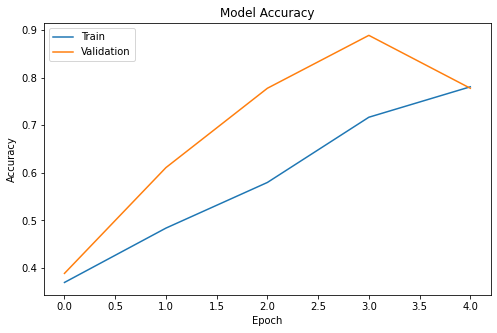

In [7]:
plt.figure(figsize=(8,5))

plt.plot(obj.history['accuracy'])
plt.plot(obj.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [8]:
model.save(r"./Models/InceptionV3.h5")

In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print("\nTest accuracy: ",test_acc)

92/92 - 8s - loss: 0.8484 - accuracy: 0.7500

Test accuracy:  0.75


2022-03-14 23:01:20.950109: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 23:01:22.970983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


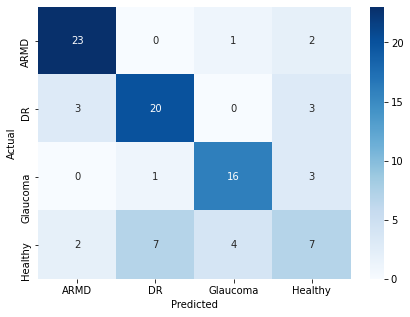

In [5]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model(r"./Models/InceptionV3.h5")
filenames = test_generator.filenames

# print(filenames)

nb_samples = len(test_generator)
y_prob = []
y_act = []
figure(figsize=(7, 5))
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

# print([i for i in actaul_class])


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True, fmt='d' )

plt.show()
# print("test accuracy : {}".format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum()*100)))

In [6]:
correctPredictions = {'ARMD' : confusion_matrix['ARMD']['ARMD'], 'DR' : confusion_matrix['DR']['DR'], 'Glaucoma' : confusion_matrix['Glaucoma']['Glaucoma'], 'Healthy' : confusion_matrix['Healthy']['Healthy']}

deNames = ['ARMD','DR','Glaucoma','Healthy']
totalCases = {'ARMD' : 0,'DR' : 0,'Glaucoma': 0,'Healthy': 0}
for name in deNames:
    for i in range(0,len(confusion_matrix[name])):
        if(i == 0):
            totalCases['ARMD'] += confusion_matrix[name][i]
        elif(i == 1):
            totalCases['DR'] += confusion_matrix[name][i]
        elif(i == 2):
            totalCases['Glaucoma'] += confusion_matrix[name][i]
        else:
            totalCases['Healthy'] += confusion_matrix[name][i]
# print(totalCases)

print("Test Accuracies : \n")
print("ARMD      :",correctPredictions['ARMD']/totalCases['ARMD'])
print("DR        :",correctPredictions['DR']/totalCases['DR'])
print("Glaucoma  :",correctPredictions['Glaucoma']/totalCases['Glaucoma'])
print("Healthy   :",correctPredictions['Healthy']/totalCases['Healthy'])

Test Accuracies : 

ARMD      : 0.8846153846153846
DR        : 0.7692307692307693
Glaucoma  : 0.8
Healthy   : 0.35


In [11]:
pd.set_option('display.max_rows', None)
print(out_df)

   predicted_class actual_class
0             ARMD         ARMD
1          Healthy           DR
2         Glaucoma     Glaucoma
3          Healthy      Healthy
4          Healthy      Healthy
5          Healthy      Healthy
6               DR           DR
7               DR           DR
8               DR           DR
9         Glaucoma     Glaucoma
10              DR           DR
11              DR           DR
12         Healthy      Healthy
13              DR           DR
14            ARMD           DR
15            ARMD         ARMD
16            ARMD         ARMD
17              DR           DR
18              DR           DR
19         Healthy           DR
20        Glaucoma     Glaucoma
21            ARMD         ARMD
22              DR      Healthy
23        Glaucoma     Glaucoma
24              DR           DR
25            ARMD         ARMD
26            ARMD         ARMD
27            ARMD         ARMD
28            ARMD         ARMD
29              DR           DR
30      